# Create Cell Cycle Binary_correlation_plot

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import gseapy as gp
import re

import cptac
import cptac.utils as u

import plot_utils as pu

In [2]:
# Returns a dataframe with proteomics and mutation type

# all_prot: list of trans genes

def all_prot_format_df(cancer_object, all_prot, gene_in = 'PTEN'):
    mut_type = cancer_object.get_genotype_all_vars(gene_in)
    
    if cancer_object.get_cancer_type() not in ('luad'):
        # Keep only tumor samples from proteomics
        prot_and_mutations = cancer_object.join_omics_to_mutations(
            mutations_genes = [gene_in], omics_df_name = 'proteomics', omics_genes = all_prot)
        # Reduce a multiindex 
        if isinstance(prot_and_mutations.keys(), pd.core.indexes.multi.MultiIndex):
            prot_and_mutations = cancer_object.reduce_multiindex(prot_and_mutations, levels_to_drop = 1)
        prot_and_mutations = prot_and_mutations[prot_and_mutations.Sample_Status == "Tumor"] # drop Normal samples

        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        mut_type = mut_type[['Mutation']] 
        prot_df = prot_and_mutations.iloc[:,:-4] # Keep only proteomics
        merged = prot_df.join(mut_type)
        
        # Keep only Wildtype and deletion
        compare = ['Wildtype_Tumor','Deletion']
        get = merged['Mutation'].isin(compare)
        del_wt = merged[get]
    
    
    # Luad has no somatic mutations for PTEN which changes some things
    else: 
        # get_genotype_all_vars add cnv data under the column PTEN
        mut_type = mut_type.drop(columns= gene_in)
        # different code because no somatic mutation data for pten (can't join to somatic mutations)
        omics = cancer_object.join_omics_to_omics(df1_name = 'CNV', df2_name='proteomics',genes1= gene_in, 
            genes2= all_prot)
        omics = cancer_object.reduce_multiindex(omics, levels_to_drop = 1, flatten = True)
        omics = omics.drop(columns='PTEN_CNV')
        # Get only tumor samples
        p = cancer_object.get_proteomics(tissue_type='tumor')
        tumor_ids = list(p.index)
        get = omics.index.isin(tumor_ids)
        omics = omics[get]
        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        merged = omics.join(mut_type) 
        # Keep only No_Mutation (wildtype) and deletion
        compare = ['No_Mutation','Deletion']
        get = merged['Mutation'].isin(compare)
        del_wt = merged[get]
        del_wt['Mutation'] = np.where(
            del_wt['Mutation'] == 'No_Mutation', 'Wildtype_Tumor', 'Deletion')

    return del_wt


# Select two cancers for the plot

In [3]:
en = cptac.Endometrial()
g = cptac.Gbm()

cptac warning: The GBM dataset is under publication embargo until March 01, 2021. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 2)


In [7]:
root = R'~\Github\WhenMutationsDontMatter\PTEN\Step_3_trans_effect\csv'
en_df = pd.read_csv(root+R'\endo_pval_medians.csv')
g_df = pd.read_csv(root+R'\gbm_pval_medians.csv')

# Calculate FDR-bh (lowest sig p-value = cutoff)

Gbm t-tests

In [20]:
gene = 'PTEN'
g_prot = g.get_proteomics()
g_prot_list = list(g_prot.columns)

g_del_wt = all_prot_format_df(g, g_prot_list, gene)
g_del_wt = g_del_wt.dropna(axis='columns', how='all')

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 72 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 394)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: C3L-01834 (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 394)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 82 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 11)


In [21]:
cols = list(g_del_wt.columns[:-1])
print(len(cols))

# Get only sig genes
g_sig = u.wrap_ttest(g_del_wt, 'Mutation', cols, correction_method = 'fdr_bh')

# get_smallest p-value
cutoff_gbm = g_sig.P_Value[-1:]
cutoff_gbm

11141


C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\Users\brittany henderson\Anaconda3\e

1886    0.008467
Name: P_Value, dtype: float64

Endo t-tests

In [22]:
gene = 'PTEN'
prot = en.get_proteomics()
p = list(prot.columns)

mut_type = en.get_genotype_all_vars(gene)

# merge cnv with genotype all mut type
prot_and_mutations = en.join_omics_to_mutations(
    mutations_genes = [gene], omics_df_name = 'proteomics', omics_genes = p)
prot_and_mutations = prot_and_mutations[prot_and_mutations.Sample_Status == "Tumor"] # drop Normal samples
df = prot_and_mutations.iloc[:,:-4] #drop mutation, location cols
mut_type = mut_type[['Mutation']] 
merged = df.join(mut_type) # merge mutation col from function (includes cnv)

# Keep two values to compare
compare = ['Wildtype_Tumor','Nonsense_Mutation','Frame_Shift_Ins','Frame_Shift_Del']
get = merged['Mutation'].isin(compare)
trunc_wt = merged[get]
trunc_wt['Mutation'] = np.where(
                trunc_wt['Mutation'] == 'Wildtype_Tumor', 'Wildtype_Tumor', 'Truncation')
trunc_wt = trunc_wt.dropna(axis='columns',how='all')

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 20 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 394)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 69 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 9)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:
cols = list(trunc_wt.columns[:-1])
print(len(cols))

# Get only sig sites
e_sig = u.wrap_ttest(trunc_wt, 'Mutation', cols, correction_method = 'fdr_bh')

# get_smallest p-value
cutoff_en = e_sig.P_Value[-1:]
cutoff_en

10993


401    0.001826
Name: P_Value, dtype: float64

In [24]:
print(len(cols))

10993


# Create df with p-values for all genes in a pathway

In [9]:
# get a list of genes in a complete Pathway 
#all_dna_rep = 'DNA2 FEN1 LIG1 MCM2 MCM3 MCM4 MCM5 MCM6 MCM7 PCNA POLA1 POLA2 POLD1 POLD2 POLD3 POLD4 POLE POLE2 POLE3 POLE4 PRIM1 PRIM2 RFC1 RFC2 RFC3 RFC4 RFC5 RNASEH1 RNASEH2A RNASEH2B RNASEH2C RPA1 RPA2 RPA3 RPA4 SSBP1'
#all_dna_genes = all_dna_rep.split(' ')

In [ ]:
'''
# kegg_2016  
cell_cycle = ('ANAPC1 ANAPC10 ANAPC11 ANAPC13 ANAPC2 ANAPC4 ANAPC5 ANAPC7 ATM ATR BUB1 BUB1B BUB3 CCNA1 CCNA2 CCNB1 '+
              'CCNB2 CCNB3 CCND1 CCND2 CCND3 CCNE1 CCNE2 CCNH CDC14A CDC14B CDC16 CDC20 CDC23 CDC25A CDC25B CDC25C '+
              'CDC26 CDC27 CDC45 CDC6 CDC7 CDK1 CDK2 CDK4 CDK6 CDK7 CDKN1A CDKN1B CDKN1C CDKN2A CDKN2B CDKN2C CDKN2D '+
              'CHEK1 CHEK2 CREBBP CUL1 DBF4 E2F1 E2F2 E2F3 E2F4 E2F5 EP300 ESPL1 FZR1 GADD45A GADD45B GADD45G GSK3B '+
              'HDAC1 HDAC2 MAD1L1 MAD2L1 MAD2L2 MCM2 MCM3 MCM4 MCM5 MCM6 MCM7 MDM2 MYC ORC1 ORC2 ORC3 ORC4 ORC5 ORC6 '+
              'PCNA PKMYT1 PLK1 PRKDC PTTG1 PTTG2 RAD21 RB1 RBL1 RBL2 RBX1 SFN SKP1 SKP2 SMAD2 SMAD3 SMAD4 SMC1A SMC1B '+
              'SMC3 STAG1 STAG2 TFDP1 TFDP2 TGFB1 TGFB2 TGFB3 TP53 TTK WEE1 WEE2 YWHAB YWHAE YWHAG YWHAH YWHAQ YWHAZ '+
              'ZBTB17')
cell_cycle = cell_cycle.split(' ')'''

In [49]:
rcc = pd.read_excel(root+R"\Reactome_cell_cycle.xlsx", sheet_name='cell_cycle')
rgs = pd.read_excel(root+R"\Reactome_cell_cycle.xlsx", sheet_name='g1_to_s')

In [50]:
reactome_cell_cycle = list(rcc.columns)
cell_cycle_list = reactome_cell_cycle[2:]

In [53]:
reactome_g1_to_s = list(rgs.columns)
g1_to_s_list = reactome_g1_to_s[2:]

In [65]:
len(cell_cycle_list)

674

In [66]:
# Merge dfs of both cancers and keep only genes in a complete pathway
merged = g_df.merge(en_df, on ='Proteomics', how='outer')
merged = merged.replace(regex=True,to_replace='_proteomics', value='')
dna_bool = merged.Proteomics.isin(cell_cycle_list)
df = merged[dna_bool]
df.head()
len(df)

534

In [67]:
# Create pval only df for Color mapping
pval_df = df.drop(columns = ['Gbm_Median','En_Median'])
pval_df = pval_df.set_index('Proteomics')
pval_df.head()

,Gbm_P_Value,En_P_Value
Proteomics,,
DCTN1,1.016640e-08,0.000275
ACTR1A,3.600370e-08,0.020618
MAPK3,1.020660e-06,0.272111
DCTN3,2.683160e-06,0.008462
BRCC3,3.222041e-06,0.537955


# Create the color column based on significance in both cancers 

In [68]:
def Color(row):
    color = 'Not_sig'

    c1_cutoff = .008667 # lowest p-value for cancer 1
    c2_cutoff = 0.001826

    for item in row:
        if pd.isnull(item):
            continue
        if row['Gbm_P_Value'] <= c1_cutoff and row['En_P_Value'] <= c2_cutoff:
            color = 'Both_sig'
        elif row['Gbm_P_Value'] <= c1_cutoff:
            color = 'Gbm_sig'
        elif row['En_P_Value'] <= c2_cutoff:
            color = 'En_sig'
           
    return color

In [69]:
print('lowest p-value for Gbm:',cutoff_gbm, '\n')
print('lowest p-value for Endo:',cutoff_en)

lowest p-value for Gbm: 1886    0.008467
Name: P_Value, dtype: float64 

lowest p-value for Endo: 401    0.001826
Name: P_Value, dtype: float64


In [70]:
pval_df['color'] = pval_df.apply(Color, axis=1)
color = pval_df[['color']]
pval_df.loc[pval_df['color'] == 'Both_sig']


,Gbm_P_Value,En_P_Value,color
Proteomics,,,
DCTN1,1.016640e-08,2.745604e-04,Both_sig
PCM1,5.112435e-05,1.373028e-04,Both_sig
TPR,8.168249e-05,1.551381e-03,Both_sig
CDK11B,2.385733e-04,4.887783e-04,Both_sig
XPO1,2.562398e-04,3.986490e-04,Both_sig
CHTF8,4.442805e-04,3.814478e-04,Both_sig
CHTF18,5.312572e-04,1.196647e-03,Both_sig
RFC2,5.795218e-04,6.505986e-04,Both_sig
NUF2,5.966527e-04,1.108534e-03,Both_sig


# Format df for plot. Add color column and keep correlations.

In [71]:
color_df = color.reset_index()
plot_df = df.merge(color_df, on='Proteomics')
plot_df= plot_df.drop(columns=['Gbm_P_Value','En_P_Value'])
plot_df.head()
len(plot_df)

534

# Plot

In [74]:
# note: use same order of df for axis names (1st col = x, 2nd col = y)
def binary_corr_plot(prepared_df, x_axis_name, y_axis_name, title, save_file_name=None):
    
    color_dict = {'Both_sig':'green',
                  'En_sig':'yellow',
                  'Gbm_sig': 'blue',
                  'Not_sig': 'grey'}
    
    sns.set(font_scale = 1.2)
    #sns.axes_style("whitegrid")
    plt.figure(figsize=(7, 7))
    all_pvals = sns.scatterplot(x=prepared_df.columns[1], y=prepared_df.columns[2], data=prepared_df,
                               hue=prepared_df.columns[3], palette=color_dict)
    all_pvals.set_title(title)
        
    plt.xlabel(x_axis_name)
    plt.ylabel(y_axis_name)
    #plt.xlim(-1.3, 1.5) 
    #plt.ylim(-1.3, 1.3)
    
    if save_file_name is not None:
        plt.savefig(save_file_name+'.png')
    plt.show()
    #plt.clf()
    plt.close()
    return 0


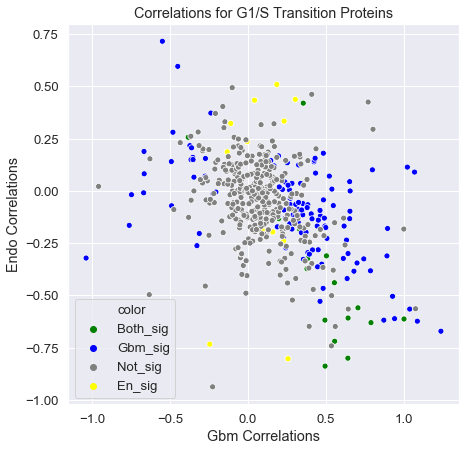

0

In [75]:
binary_corr_plot(plot_df, 'Gbm Correlations', 'Endo Correlations','Correlations for G1/S Transition Proteins')